# Complete

In [14]:
run_from = 'google_colab'
NUM_EPOCHS = 150
size = 128
train_with, mask = 'only', 'spiral_mask'
min_vote = 3
threshold = 1
patience = 5

# Libraries

In [15]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import random
import os
from datetime import datetime
from sklearn.metrics import confusion_matrix, jaccard_score
from keras.callbacks import CSVLogger, EarlyStopping, ModelCheckpoint



if run_from == 'google_colab':

    from google.colab import drive

    drive.mount('/content/drive')
    !mkdir /root/tensorflow_datasets
    !cp -r /content/drive/MyDrive/tensorflow_dataset/galaxy_zoo3d /root/tensorflow_datasets/.
    
    
elif run_from == 'amazon_sagemaker':
    
    import matplotlib as mpl
    
    mpl.rcParams['xtick.color'] = 'w'
    mpl.rcParams['ytick.color'] = 'w'
    mpl.rcParams['xtick.labelcolor'] = 'w'
    mpl.rcParams['axes.labelcolor'] = 'w'
    mpl.rcParams['axes.titlecolor'] = 'w'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
mkdir: cannot create directory ‘/root/tensorflow_datasets’: File exists


# Data

## Useful functions

In [16]:
def resize(input_image, input_mask):
    input_image = tf.image.resize(input_image, (size, size), method="nearest")
    input_mask = tf.image.resize(input_mask, (size, size), method="nearest")

    return input_image, input_mask 


def augment(input_image, input_mask):
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_up_down(input_image)
        input_mask = tf.image.flip_up_down(input_mask)

    return input_image, input_mask


def normalize(input_image):
    input_image = tf.cast(input_image, tf.float32) / 255.0
  
    return input_image


def binary_mask(input_mask):
    th = threshold
    input_mask = tf.where(input_mask<th, tf.zeros_like(input_mask), tf.ones_like(input_mask))
    
    return input_mask
    
    
def load_image_train(datapoint):
    input_image = datapoint['image']
    input_mask = datapoint[mask]
    input_image, input_mask = resize(input_image, input_mask)
    input_image, input_mask = augment(input_image, input_mask)
    input_image = normalize(input_image)
    input_mask = binary_mask(input_mask)

    return input_image, input_mask


def load_image_test(datapoint):
    input_image = datapoint['image']
    input_mask = datapoint[mask]
    input_image, input_mask = resize(input_image, input_mask)
    input_image = normalize(input_image)
    input_mask = binary_mask(input_mask)

    return input_image, input_mask


def display(display_list):
  plt.figure(figsize=(15, 15))
  titles = ['Image', 'Mask', 'Prediction']
  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.title(titles[i])
    plt.axis("off")
  plt.show()

## Data loader

In [17]:
ds, info = tfds.load('galaxy_zoo3d', split=['train[:75%]', 'train[75%:]'], with_info=True)
ds_train, ds_test = ds[0], ds[1]

if train_with == 'all':
  BUFFER_SIZE, BATCH_SIZE = 1000, 64
  TRAIN_LENGTH, VAL_SIZE, TEST_SIZE = 22360, 4992, 2461
elif train_with == 'only':
  BUFFER_SIZE, BATCH_SIZE = 300, 32
  if mask == 'spiral_mask':
    ds_train = ds_train.filter(lambda x: tf.reduce_max(x['spiral_mask']) >= min_vote)      
    ds_test = ds_test.filter(lambda x: tf.reduce_max(x['spiral_mask']) >= min_vote)
    TRAIN_LENGTH, VAL_SIZE, TEST_SIZE = 4883, 1088, 551
  elif mask == 'bar_mask':
    ds_train = ds_train.filter(lambda x: tf.reduce_max(x['bar_mask']) >= min_vote)
    ds_test = ds_test.filter(lambda x: tf.reduce_max(x['bar_mask']) >= min_vote)
    TRAIN_LENGTH, VAL_SIZE, TEST_SIZE = 3783, 832, 421

In [18]:
train_dataset = ds_train.map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = ds_test.map(load_image_test, num_parallel_calls=tf.data.AUTOTUNE)

train_batches = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_batches = test_dataset.take(VAL_SIZE).batch(BATCH_SIZE)
test_batches = test_dataset.skip(VAL_SIZE).take(TEST_SIZE).batch(BATCH_SIZE)

# U-Net

## Model

In [19]:
def double_conv_block(x, n_filters):

    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)

    return x


def downsample_block(x, n_filters):
    
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.3)(p)

    return f, p


def upsample_block(x, conv_features, n_filters):
    
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    x = layers.concatenate([x, conv_features])
    x = layers.Dropout(0.3)(x)
    x = double_conv_block(x, n_filters)

    return x

In [20]:
def build_unet_model():

    inputs = layers.Input(shape=(size,size,3))

    f1, p1 = downsample_block(inputs, size/2)
    f2, p2 = downsample_block(p1, size)
    f3, p3 = downsample_block(p2, size*2)
    f4, p4 = downsample_block(p3, size*4)

    bottleneck = double_conv_block(p4, size*8)

    u6 = upsample_block(bottleneck, f4, size*4)
    u7 = upsample_block(u6, f3, size*2)
    u8 = upsample_block(u7, f2, size)
    u9 = upsample_block(u8, f1, size/2)

    outputs = layers.Conv2D(2, 1, padding="same", activation = "softmax")(u9)

    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

    return unet_model

## Callbacks

In [21]:
date = datetime.now().strftime("%Y_%m_%d-%H:%M:%S")
filename = f'{date}_{train_with}_'+mask.split('_')[0]+'-'+mask.split('_')[1]+f'_epochs:{NUM_EPOCHS}_size:{size}_th:{threshold}_patience:{patience}'
if run_from == 'google_colab':
    path = '/content/drive/MyDrive/Galaxy Segmentation Project/Modelos/'
elif run_from == 'amazon_sagemaker':
    path = '/home/studio-lab-user/sagemaker-studiolab-notebooks/Galaxy Segmentation Project/Modelos/'
os.mkdir(f'{path}{filename}')

csv_log = CSVLogger(f'{path}{filename}/{filename}.csv')
early_stop = EarlyStopping(monitor='val_loss', patience=patience, mode='min')
mcp_save_best = ModelCheckpoint(filepath=f'{path}{filename}/{filename}_best.h5', monitor='val_accuracy', mode='max', save_best_only=True)
mcp_save_last = ModelCheckpoint(filepath=f'{path}{filename}/{filename}_last.h5')

## Training

In [22]:
unet_model = build_unet_model()

unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                   loss="sparse_categorical_crossentropy",
                   metrics="accuracy"
                  )

STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

VAL_SUBSPLITS = 5
TEST_LENGTH = VAL_SIZE + TEST_SIZE
VALIDATION_STEPS = TEST_LENGTH // BATCH_SIZE // VAL_SUBSPLITS

model_history = unet_model.fit(train_batches,
                               epochs=NUM_EPOCHS,
                               steps_per_epoch=STEPS_PER_EPOCH,
                               validation_steps=VALIDATION_STEPS,
                               validation_data=validation_batches,
                               callbacks=[csv_log, early_stop, mcp_save_best, mcp_save_last])

Epoch 1/150
152/152 [==============================] - 332s 2s/step - loss: 0.5347 - accuracy: 0.8825 - val_loss: 0.2348 - val_accuracy: 0.9014
Epoch 2/150
152/152 [==============================] - 102s 638ms/step - loss: 0.2338 - accuracy: 0.9015 - val_loss: 0.2293 - val_accuracy: 0.9022
Epoch 3/150
152/152 [==============================] - 98s 643ms/step - loss: 0.2281 - accuracy: 0.9034 - val_loss: 0.2271 - val_accuracy: 0.9043
Epoch 4/150
152/152 [==============================] - 94s 622ms/step - loss: 0.2255 - accuracy: 0.9043 - val_loss: 0.2286 - val_accuracy: 0.9025
Epoch 5/150
152/152 [==============================] - 100s 662ms/step - loss: 0.2245 - accuracy: 0.9049 - val_loss: 0.2241 - val_accuracy: 0.9046
Epoch 6/150
152/152 [==============================] - 98s 644ms/step - loss: 0.2240 - accuracy: 0.9054 - val_loss: 0.2225 - val_accuracy: 0.9057
Epoch 7/150
152/152 [==============================] - 92s 607ms/step - loss: 0.2229 - accuracy: 0.9059 - val_loss: 0.2226 -

# Learning curves

## Display functions

In [23]:
def display_learning_curves(history):

    val_acc = history.history["val_accuracy"]
    acc = history.history["accuracy"]

    val_loss = history.history["val_loss"]
    loss = history.history["loss"]

    epochs_range = range(len(loss))

    fig, ax = plt.subplots(1, 2, figsize=(12,6))

    ax[0].plot(epochs_range, loss, label="train loss", linewidth=2.5)
    ax[0].plot(epochs_range, val_loss, label="validation loss", linewidth=2.5)
    ax[0].set_xlabel("Epoch", fontsize=20, labelpad=10)
    ax[0].set_ylabel("Loss", fontsize=20, labelpad=10)
    ax[0].set_ylim(min(min(loss), min(val_loss)), max(max(loss[1:]), max(val_loss[1:])))
    ax[0].tick_params(axis='both', labelsize=15)
    ax[0].legend(loc="best", fontsize=15)

    ax[1].plot(epochs_range, acc, label="train accuracy", linewidth=2.5)
    ax[1].plot(epochs_range, val_acc, label="validation accuracy", linewidth=2.5)
    ax[1].set_xlabel("Epoch", fontsize=20, labelpad=10)
    ax[1].set_ylabel("Accuracy", fontsize=20, labelpad=10)
    ax[1].tick_params(axis='both', labelsize=15)
    ax[1].legend(loc="best", fontsize=15)

    fig.tight_layout()
    fig.show()

## Learning graphs

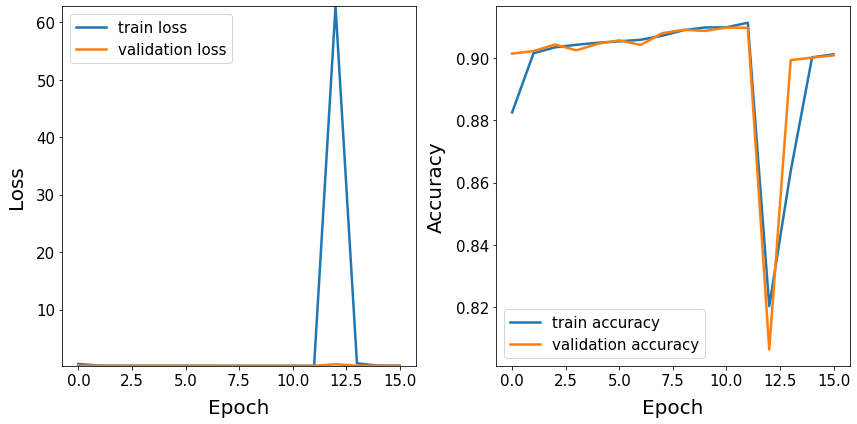

In [24]:
display_learning_curves(unet_model.history)

# Predictions

## Prediction funcitons

In [25]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask


def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset:
      pred_mask = create_mask(unet_model.predict(image))
      for ind in range(num):
        display([image[ind], mask[ind], pred_mask[ind]])
        if np.amax(pred_mask[ind].numpy()) == 0:
          print(2*'\n')
          continue
        else:
          conf_matrix = confusion_matrix(pred_mask[ind].numpy().reshape(-1), mask[ind].numpy().reshape(-1))
          jacc_score = jaccard_score(pred_mask[ind].numpy().reshape(-1), mask[ind].numpy().reshape(-1))
          print('Confusion matrix:     Precision:    Sensitivity/Recall:   Specificity:      Jaccard score: \n',
          conf_matrix, '\t',
          round(conf_matrix[1,1]/(conf_matrix[1,0]+conf_matrix[1,1]), 2), 2*'\t  ',
          round(conf_matrix[1,1]/(conf_matrix[0,1]+conf_matrix[1,1]), 2), '\t     ',
          round(conf_matrix[0,0]/(conf_matrix[0,0]+conf_matrix[1,0]), 2), 2*'\t',
          round(jacc_score, 2), '\n')

## Prediction examples

In [26]:
show_predictions(test_batches.skip(random.randint(0, 15)).take(1), 25)

Output hidden; open in https://colab.research.google.com to view.